In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [2]:
def gaussian_like(mean, variance, std):
        # Create a Gaussian distribution with the given mean and variance
        distribution = torch.distributions.Normal(mean, variance.sqrt())

        # Sample from the distribution and scale by the standard deviation
        sample = distribution.sample()
        output = sample * std

        return output

def beta_distribution_like(alpha, beta, std):
    # Create a Beta distribution with the given alpha and beta
    distribution = torch.distributions.Beta(alpha, beta)

    # Sample from the distribution and scale by the standard deviation
    sample = distribution.sample()
    output = sample * std

    return output

def gamma_distribution_like(alpha, beta, std):
    # Create a Gamma distribution with the given alpha and beta
    distribution = torch.distributions.Gamma(alpha, beta)

    # Sample from the distribution and scale by the standard deviation
    sample = distribution.sample()
    output = sample * std

    return output

In [ ]:
# IGNORE BELOW
# standard normal
def sampling_standard_normal(self, mu, log_var):
    # std = torch.exp(0.5*log_var)
    # eps = torch.distributions.Normal(0,1)
    # return torch.distributions.Normal(mu, log_var).sample().mul(torch.exp(0.5*log_var)).add_(mu)
    return torch.distributions.Normal(mu, log_var).sample()

# mean = 1, std = 2
def gaussian_sampling(self, mu, log_var):
    return torch.distributions.Normal(1, 2).sample()

# beta distribution
def beta_sampling(self, alpha, beta):
    alpha = torch.ones_like(alpha) * 2  # set alpha to 2
    beta = torch.ones_like(beta) * 2  # set beta to 2
    return torch.distributions.beta.Beta(alpha, beta).sample()

# gamma 3,2 distribution
def gamma_sampling(self, alpha, beta):
    alpha = torch.ones_like(alpha) * 3  # set alpha to 3
    beta = torch.ones_like(beta) * 2  # set beta to 2
    return torch.distributions.gamma.Gamma(alpha, beta).sample()

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling_normal(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) #
        return eps.mul(std).add_(mu) # return z sample


    def sampling_gaussian(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = gaussian_like(torch.tensor(1.0),torch.tensor(2.0), std) #
        return eps.mul(std).add_(mu) # return z sample

    def sampling_beta(self, alpha, beta):
        # https://math.stackexchange.com/questions/2362780/prove-the-normal-approximation-of-beta-distribution
        # thinking along approximating beta to normal distribution
        return beta_distribution_like(alpha, beta, 1.0)

    def sampling_gamma(self, alpha, beta):
        return gamma_distribution_like(alpha, beta, 1.0)

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling_normal(mu, log_var)
        # z = self.sampling_gaussian(mu, log_var)
        # z = self.sampling_beta(mu, log_var) // alpha, beta
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [4]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [7]:
# Define training parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 50

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
# vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


## will have to change this fn for gaussian (1,2), beta distribution...
# does not matter much with gaussian as it is just "shifted" so model can learn accordingly but still not a good idea.... so we fix the loss
# function according to how we degine the latent space distribution

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
import torch.nn.functional as F

## not so sure on how to compute KL divergence for beta distribution

def vae_loss(recon_x, x, mu, logvar, distribution='gaussian'):
    if distribution == 'gaussian':
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    elif distribution == 'beta':
        alpha = mu
        beta =logvar
        prior_alpha = recon_x
        prior_beta = x
        BCE = -torch.sum(x * torch.log(recon_x) + (1 - x) * torch.log(1 - recon_x))

        KLD = -0.5 * torch.sum(1 + logvar - torch.log(beta) + (beta - 1) * (torch.digamma(beta) - torch.digamma(alpha + beta)) + (alpha - prior_alpha) / prior_alpha + (beta - prior_beta) / prior_beta)

    return BCE + KLD

    else:
        raise NotImplementedError("Unsupported distribution type")

    return BCE + KLD



In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available; moving model to GPU.")
    vae.to(device)
else:
    device = torch.device("cpu")
    print("GPU is not available; using CPU.")

GPU is available; moving model to GPU.


In [13]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [14]:
# Training loop
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 1/50: 100%|██████████| 469/469 [00:09<00:00, 51.35it/s]


Epoch 1/50, Loss: 183.2603045735677


Epoch 2/50: 100%|██████████| 469/469 [00:10<00:00, 44.70it/s]


Epoch 2/50, Loss: 159.35501858723958


Epoch 3/50: 100%|██████████| 469/469 [00:08<00:00, 53.52it/s]


Epoch 3/50, Loss: 153.73739651692708


Epoch 4/50: 100%|██████████| 469/469 [00:08<00:00, 53.87it/s]


Epoch 4/50, Loss: 150.34895994466146


Epoch 5/50: 100%|██████████| 469/469 [00:07<00:00, 58.69it/s]


Epoch 5/50, Loss: 148.0862199544271


Epoch 6/50: 100%|██████████| 469/469 [00:10<00:00, 46.13it/s]


Epoch 6/50, Loss: 146.52207849934896


Epoch 7/50: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]


Epoch 7/50, Loss: 145.4949905110677


Epoch 8/50: 100%|██████████| 469/469 [00:08<00:00, 53.86it/s]


Epoch 8/50, Loss: 144.53578331705728


Epoch 9/50: 100%|██████████| 469/469 [00:08<00:00, 53.89it/s]


Epoch 9/50, Loss: 143.86493025716146


Epoch 10/50: 100%|██████████| 469/469 [00:07<00:00, 58.66it/s]


Epoch 10/50, Loss: 143.05542345377603


Epoch 11/50: 100%|██████████| 469/469 [00:09<00:00, 50.95it/s]


Epoch 11/50, Loss: 142.56736977539063


Epoch 12/50: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]


Epoch 12/50, Loss: 142.00809381510416


Epoch 13/50: 100%|██████████| 469/469 [00:10<00:00, 44.26it/s]


Epoch 13/50, Loss: 141.57235380859376


Epoch 14/50: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]


Epoch 14/50, Loss: 141.16353881835937


Epoch 15/50: 100%|██████████| 469/469 [00:08<00:00, 53.34it/s]


Epoch 15/50, Loss: 140.80656061197917


Epoch 16/50: 100%|██████████| 469/469 [00:08<00:00, 57.67it/s]


Epoch 16/50, Loss: 140.60517724609375


Epoch 17/50: 100%|██████████| 469/469 [00:08<00:00, 53.54it/s]


Epoch 17/50, Loss: 140.22091845703125


Epoch 18/50: 100%|██████████| 469/469 [00:11<00:00, 41.78it/s]


Epoch 18/50, Loss: 140.05177029622396


Epoch 19/50: 100%|██████████| 469/469 [00:10<00:00, 44.94it/s]


Epoch 19/50, Loss: 139.5868069986979


Epoch 20/50: 100%|██████████| 469/469 [00:10<00:00, 46.26it/s]


Epoch 20/50, Loss: 139.39451393229166


Epoch 21/50: 100%|██████████| 469/469 [00:08<00:00, 55.16it/s]


Epoch 21/50, Loss: 139.08136204427083


Epoch 22/50: 100%|██████████| 469/469 [00:08<00:00, 53.03it/s]


Epoch 22/50, Loss: 138.62963269856772


Epoch 23/50: 100%|██████████| 469/469 [00:08<00:00, 53.04it/s]


Epoch 23/50, Loss: 138.68344752604168


Epoch 24/50: 100%|██████████| 469/469 [00:08<00:00, 56.42it/s]


Epoch 24/50, Loss: 138.5581923502604


Epoch 25/50: 100%|██████████| 469/469 [00:08<00:00, 53.32it/s]


Epoch 25/50, Loss: 138.43566062825522


Epoch 26/50: 100%|██████████| 469/469 [00:08<00:00, 52.99it/s]


Epoch 26/50, Loss: 138.05040875651042


Epoch 27/50: 100%|██████████| 469/469 [00:09<00:00, 48.37it/s]


Epoch 27/50, Loss: 137.80938372395832


Epoch 28/50: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]


Epoch 28/50, Loss: 137.641792578125


Epoch 29/50: 100%|██████████| 469/469 [00:08<00:00, 57.86it/s]


Epoch 29/50, Loss: 137.89679705403645


Epoch 30/50: 100%|██████████| 469/469 [00:08<00:00, 53.55it/s]


Epoch 30/50, Loss: 137.24543190104166


Epoch 31/50: 100%|██████████| 469/469 [00:08<00:00, 53.35it/s]


Epoch 31/50, Loss: 137.0250114420573


Epoch 32/50: 100%|██████████| 469/469 [00:08<00:00, 55.40it/s]


Epoch 32/50, Loss: 136.88256075846354


Epoch 33/50: 100%|██████████| 469/469 [00:08<00:00, 55.52it/s]


Epoch 33/50, Loss: 136.8591657389323


Epoch 34/50: 100%|██████████| 469/469 [00:08<00:00, 53.62it/s]


Epoch 34/50, Loss: 136.67146940104166


Epoch 35/50: 100%|██████████| 469/469 [00:08<00:00, 53.24it/s]


Epoch 35/50, Loss: 136.81846923828124


Epoch 36/50: 100%|██████████| 469/469 [00:08<00:00, 58.33it/s]


Epoch 36/50, Loss: 136.63825211588542


Epoch 37/50: 100%|██████████| 469/469 [00:08<00:00, 53.32it/s]


Epoch 37/50, Loss: 136.47684532877605


Epoch 38/50: 100%|██████████| 469/469 [00:08<00:00, 53.00it/s]


Epoch 38/50, Loss: 136.20830346679688


Epoch 39/50: 100%|██████████| 469/469 [00:08<00:00, 55.18it/s]


Epoch 39/50, Loss: 136.23279168294272


Epoch 40/50: 100%|██████████| 469/469 [00:08<00:00, 55.07it/s]


Epoch 40/50, Loss: 136.2013368001302


Epoch 41/50: 100%|██████████| 469/469 [00:08<00:00, 53.13it/s]


Epoch 41/50, Loss: 135.9623731608073


Epoch 42/50: 100%|██████████| 469/469 [00:08<00:00, 52.65it/s]


Epoch 42/50, Loss: 135.7517383138021


Epoch 43/50: 100%|██████████| 469/469 [00:08<00:00, 57.72it/s]


Epoch 43/50, Loss: 135.7758362141927


Epoch 44/50: 100%|██████████| 469/469 [00:08<00:00, 53.64it/s]


Epoch 44/50, Loss: 135.99444378255208


Epoch 45/50: 100%|██████████| 469/469 [00:08<00:00, 53.99it/s]


Epoch 45/50, Loss: 135.83426927083335


Epoch 46/50: 100%|██████████| 469/469 [00:08<00:00, 55.75it/s]


Epoch 46/50, Loss: 135.56877068684895


Epoch 47/50: 100%|██████████| 469/469 [00:08<00:00, 55.08it/s]


Epoch 47/50, Loss: 135.3891651529948


Epoch 48/50: 100%|██████████| 469/469 [00:08<00:00, 54.03it/s]


Epoch 48/50, Loss: 137.63611612955728


Epoch 49/50: 100%|██████████| 469/469 [00:08<00:00, 53.35it/s]


Epoch 49/50, Loss: 138.69240569661457


Epoch 50/50: 100%|██████████| 469/469 [00:08<00:00, 53.68it/s]

Epoch 50/50, Loss: 138.02023631184895


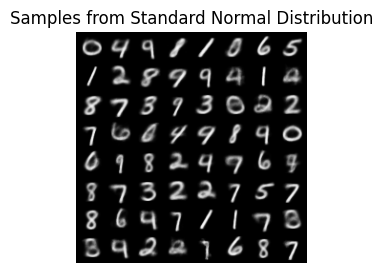

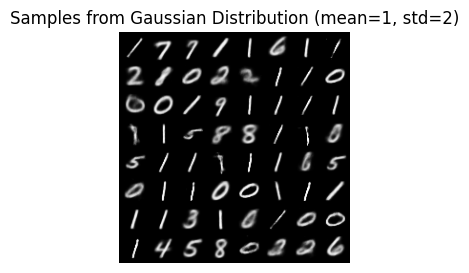

In [30]:
import matplotlib.pyplot as plt
import torchvision.utils

vae.to('cpu')

vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2) ## sample from standard normal
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'standard_normal_samples.png', nrow=8)
    plt.figure(figsize=(3, 3))
    plt.imshow(torchvision.utils.make_grid(sample, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.title('Samples from Standard Normal Distribution')
    plt.show()

vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2) * 2 + 1  # scaling the standard normal samples to gaussian 1, 2
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gaussian_samples.png', nrow=8)
    plt.figure(figsize=(3, 3))
    plt.imshow(torchvision.utils.make_grid(sample, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.title('Samples from Gaussian Distribution (mean=1, std=2)')
    plt.show()


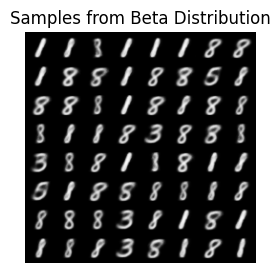

In [19]:
import torch.distributions as D

def generate_beta_samples(num_samples, latent_dim=2):
    # calculating parameters of the beta distribution
    alpha = 1
    beta = (2 - 1) / 2  #  mean = 1,  std = 2
    # sampling from the beta distribution
    beta_dist = D.Beta(alpha, beta)
    samples = beta_dist.sample((num_samples, latent_dim)).squeeze()  # remving extra dimension
    return samples

# sampling
vae.eval()
with torch.no_grad():
    z = generate_beta_samples(64)
    sample = vae.decoder(z.view(-1, 2)).view(-1, 1, 28, 28)  # Assuming latent_dim=2
    torchvision.utils.save_image(sample, 'beta_samples.png', nrow=8)
    plt.figure(figsize=(3, 3))
    plt.imshow(torchvision.utils.make_grid(sample, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.title('Samples from Beta Distribution')
    plt.show()

In [ ]:
# skip (for now)

def generate_gamma_samples(num_samples, latent_dim=2):
    concentration = torch.tensor([3.0])
    rate = torch.tensor([2.0])
    gamma_dist = D.Gamma(concentration, rate) ## cant understand exactly how to implement
    # https://www.johndcook.com/blog/normal_approx_to_gamma/
    samples = gamma_dist.sample((num_samples, latent_dim)).squeeze()
    return samples

# Generate samples from the Gamma distribution
vae.eval()
with torch.no_grad():
    z = generate_gamma_samples(64, latent_dim=2)
    z = z.unsqueeze(1).expand(-1, 256, -1)
    sample = vae.decoder(z.view(-1, 256)).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gamma_samples.png', nrow=8)
    plt.figure(figsize=(3, 3))
    plt.imshow(torchvision.utils.make_grid(sample, nrow=8).permute(1, 2, 0))
    plt.axis('off')
    plt.title('Samples from Gamma Distribution')
    plt.show()

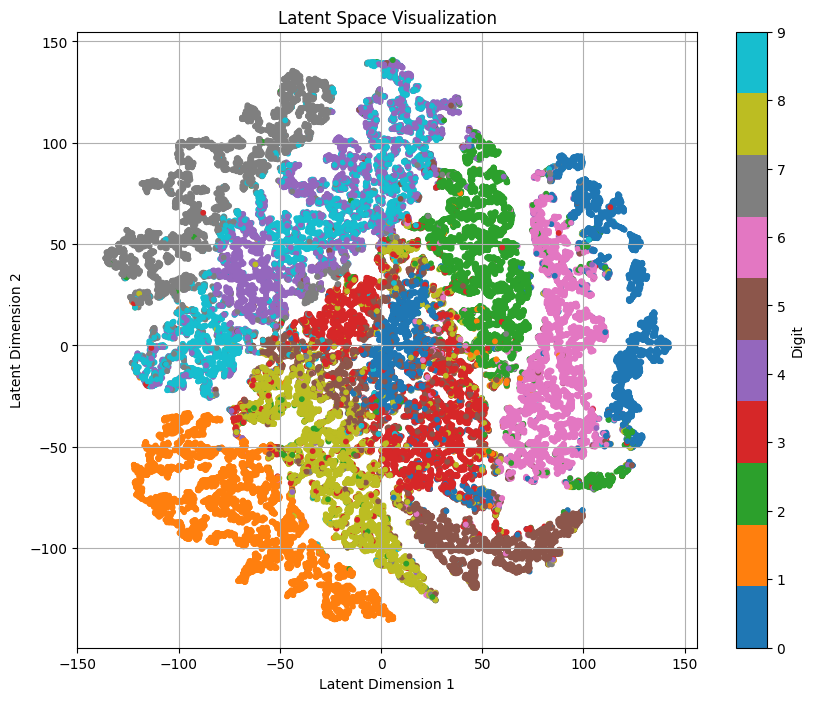

In [21]:
# using tsne for dimetionality reduction to visualize the space
# although here already have latent space of 2 dim only

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to encode input data into the latent space
def encode_data(vae, data_loader):
    vae.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            _, mu, _ = vae(data)
            latent_vectors.append(mu)
            labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)
    return latent_vectors, labels

# Encode data into the latent space
train_latent_vectors, train_labels = encode_data(vae, train_loader)

# Perform dimensionality reduction for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(train_latent_vectors)

# Plot the latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=train_labels, cmap='tab10', s=10)
plt.colorbar(label='Digit')
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()


In [40]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model.to(device)

    norm = torch.distributions.Normal(0, 1)
    grid_x = norm.icdf(torch.linspace(0.05, 0.95, n).to(device))
    grid_y = norm.icdf(torch.linspace(0.05, 0.95, n).to(device))
    image_width = digit_size * n
    image_height = image_width
    image = torch.zeros((image_height, image_width)).to(device)

    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = torch.tensor([[xi, yi]]).to(device)
                x_decoded = model.decoder(z)
                digit = x_decoded.view(digit_size, digit_size)
                image[i * digit_size: (i + 1) * digit_size,
                      j * digit_size: (j + 1) * digit_size] = digit.cpu()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

# generate animation of transitioning from one digit to another in latent space and then decoding at each step and generating image, thereby creating animation
def generate_animation_digits(model, digit1, digit2, frames, digit_size=28):
    """Generates an animation of the transition from digit1 to digit2 in the latent space."""

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model.to(device)

    with torch.no_grad():
        norm = torch.distributions.Normal(0, 1)


        d_1 = vae.encoder(torch.tensor(train_loader.dataset[digit1 - 1][0]).view(-1, 784))
        d_2 = vae.encoder(torch.tensor(train_loader.dataset[digit2 - 1][0]).view(-1, 784))

        # show d1 and d2 images and their latent space values
        plt.figure(figsize=(3, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(train_loader.dataset[digit1 - 1][0].view(28, 28), cmap='Greys_r')
        plt.title(f'Latent Space: {d_1[0].cpu().numpy()}')
        plt.axis('Off')
        plt.subplot(1, 2, 2)
        plt.imshow(train_loader.dataset[digit2 - 1][0].view(28, 28), cmap='Greys_r')
        plt.title(f'Latent Space: {d_2[0].cpu().numpy()}')
        plt.axis('Off')
        plt.show()

        z_1 = vae.sampling_normal(d_1[0], d_1[1])[0]
        z_2 = vae.sampling_normal(d_2[0], d_2[1])[0]
        print("sampling done: ", z_1, z_2)

        # find distance between two points
        distance = torch.norm(z_2 - z_1)
        # print(distance)

        # find the step size
        step_size = distance / frames
        angle = torch.atan2(z_2[1] - z_1[1], z_2[0] - z_1[0])
        # print(step_size)

        image_width = digit_size * frames
        image_height = digit_size
        image = torch.zeros((image_height, image_width)).to(device)

        ## go through each step and decode the image
        for i in range(frames):
            z = z_1 + i * step_size * torch.tensor([torch.cos(angle), torch.sin(angle)])
            # print(z)
            x_decoded = model.decoder(z)
            digit = x_decoded.view(digit_size, digit_size)
            image[:, i * digit_size: (i + 1) * digit_size] = digit.cpu()


        plt.figure(figsize=(10, 10))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('Off')
        plt.show()


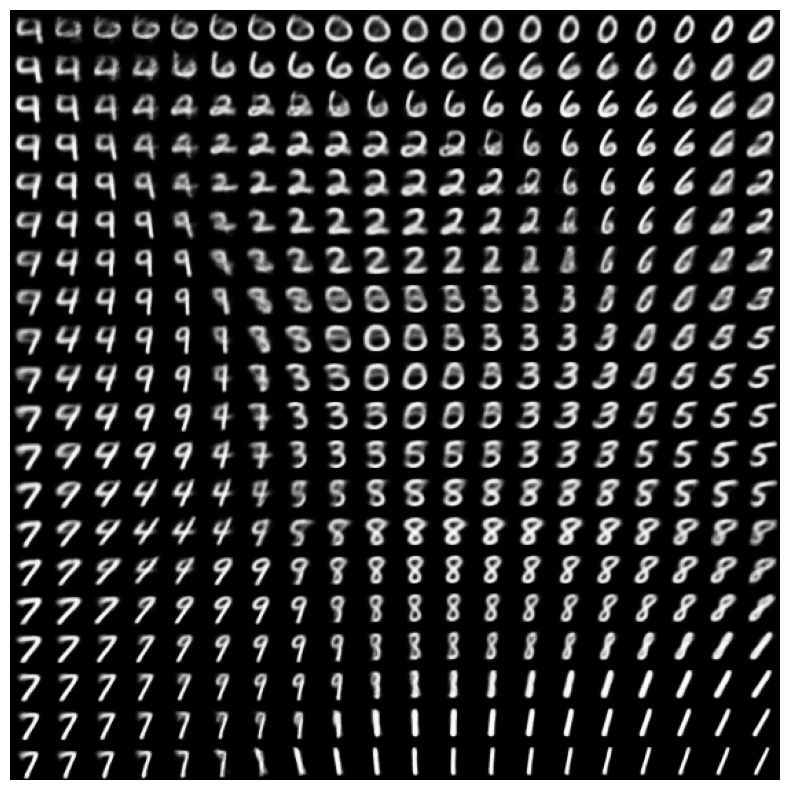

In [32]:
plot_latent_images(vae, 20)

<ipython-input-40-08101fba240b>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_1 = vae.encoder(torch.tensor(train_loader.dataset[digit1 - 1][0]).view(-1, 784))
<ipython-input-40-08101fba240b>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_2 = vae.encoder(torch.tensor(train_loader.dataset[digit2 - 1][0]).view(-1, 784))


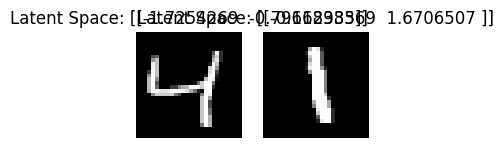

sampling done:  tensor([-1.8326, -0.7822]) tensor([-0.1278,  1.7565])


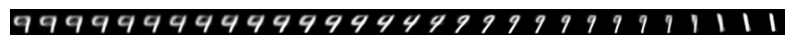

In [42]:
# visualizing transitioning from one digit to another in latent space
generate_animation_digits(vae, 3, 7, 30)

**Some Useful Resources**

Very good visualization made: https://robz.github.io/mnist-vae/

Pytorch example for VAE: [link](https://github.com/pytorch/examples/blob/main/vae/main.py)

tiny-vae implementation:
- https://fleuret.org/cgi-bin/gitweb/gitweb.cgi?p=pytorch.git;a=blob;f=tiny_vae.py
- https://github.com/lyeoni/pytorch-mnist-VAE/

detailed explanation: https://mbernste.github.io/posts/vae/

beta-vaes:
- https://lilianweng.github.io/posts/2018-08-12-vae/
- https://github.com/mdhabibi/DeepLearning-MNIST-VAE/blob/main/notebooks/MNIST_VAE_main_dim%3D5.ipynb

beta & gamma as normal distributions: https://link.springer.com/content/pdf/10.1007/BF00533744.pdf
